# Training a Cursive Transformer
Sam Greydanus | 2024

In [1]:
! pip -q install wandb
! wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import numpy as np
from scipy.ndimage import rotate
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
import os, sys, time, math, argparse, io, copy, json, pdb
from dataclasses import dataclass
from typing import List
from math import comb

import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


## Preprocessing and Tokenization

In [3]:
def plot_strokes(stroke, title, fig=None, ax=None):
    """Plot a single stroke"""
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 2))

    # Separate strokes based on pen lifts
    strokes = []
    current_stroke = []
    for point in stroke:
        if point[2] == 1:  # Pen is down
            current_stroke.append(point)
        else:  # Pen is up
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
    if current_stroke:
        strokes.append(current_stroke)

    # Plot each stroke
    for stroke in strokes:
        x, y = zip(*[(p[0], 1 - p[1]) for p in stroke])  # Invert y-axis
        ax.plot(x, y, 'b-')

    ax.set_aspect('equal') ; ax.set_title(title)

    if fig is None:
        plt.show()

    return fig, ax

def load_and_parse_data(min_ascii_length=3):
    uploaded = files.upload()
    file_content = next(iter(uploaded.values()))
    data = json.loads(file_content.decode('utf-8'))
    for i in range(len(data)):
      strokes = np.array(data[i]['points'])
      strokes[:,0:1] *= data[i]['metadata']['aspectRatio']
      strokes[:, 0] -= strokes[0, 0]
      data[i]['points'] = strokes
    data = [d for d in data if len(d['metadata']['asciiSequence']) >= min_ascii_length]
    return data

# data = load_and_parse_data()
# print(len(data))

In [4]:
def decompose_offsets(offsets):
    dx, dy = offsets[:, 0], offsets[:, 1]
    r = np.hypot(dx, dy)
    theta = np.arctan2(dy, dx)
    return np.column_stack((theta, r, offsets[:, 2]))

def reconstruct_offsets(polar_data):
    theta, r = polar_data[:, 0], polar_data[:, 1]
    dx = r * np.cos(theta)
    dy = r * np.sin(theta)
    return np.column_stack((dx, dy, polar_data[:, 2]))

def strokes_to_offsets(points):
    # Calculate differences (dx, dy), not considering pen_down
    offsets = np.zeros_like(points)
    offsets[1:, 0:2] = np.diff(points[:, 0:2], axis=0)  # Compute dx, dy
    offsets[:, 2] = points[:, 2]  # Copy pen_down directly

    # Decouple direction from magnitude (this will help with tokenization)
    offsets_dec = decompose_offsets(offsets)
    return offsets_dec

def offsets_to_strokes(offsets_dec):
    # Calculate cumulative sums to get absolute positions
    offsets = reconstruct_offsets(offsets_dec)
    absolute_coords = np.cumsum(offsets[:, :2], axis=0)
    stroke_data = np.hstack((absolute_coords, offsets[:, 2:3]))
    return stroke_data

In [5]:
def combine_handwriting_examples(examples, space_width=0.17):
    assert len(set(ex['metadata']['author'] for ex in examples)) == 1, "All examples must have the same author"

    combined_metadata = {
        'author': examples[0]['metadata']['author'],
        'asciiSequence': ' '.join(ex['metadata']['asciiSequence'] for ex in examples),
        'pointCount': sum(ex['metadata']['pointCount'] for ex in examples),
        'strokeCount': sum(ex['metadata']['strokeCount'] for ex in examples),
        'aspectRatio': examples[0]['metadata']['aspectRatio']
    }

    combined_points, current_x_offset, total_width = [], 0, 0

    for i, example in enumerate(examples):
        points = example['points']
        word_width = np.max(points[:, 0]) - np.min(points[:, 0])
        total_width += word_width

        normalized_points = points.copy()
        normalized_points[:, 0] -= np.min(points[:, 0])
        normalized_points[:, 0] += current_x_offset

        combined_points.append(normalized_points)
        current_x_offset += word_width

        if i < len(examples) - 1:
            combined_points.append(np.array([[current_x_offset + space_width, normalized_points[-1, 1], 0]]))
            current_x_offset += space_width
            total_width += space_width
            combined_metadata['pointCount'] += 1

    combined_points = np.vstack(combined_points)
    return {'metadata': combined_metadata, 'points': combined_points}

def rotate_points(points, max_angle=10):
    angle = np.deg2rad(np.random.uniform(-max_angle, max_angle))
    cos_angle, sin_angle = np.cos(angle), np.sin(angle)

    x, y = points[:, 0], points[:, 1]
    x_rot = x * cos_angle - y * sin_angle
    y_rot = x * sin_angle + y * cos_angle

    points[:, 0], points[:, 1] = x_rot, y_rot
    return points

def shear_points(points, shear_range=(-0.4, 0.4)):
    shear_factor = np.random.uniform(*shear_range)
    x, y = points[:, 0], points[:, 1]
    x_sheared = x + shear_factor * y
    points[:, 0] = x_sheared
    return points

def generate_word_combos(raw_json, desired_num_combos=10000, num_words=3, max_angle=4, shear_range=(-0.4, 0.4)):
  num_combos = comb(len(raw_json), num_words)
  print(f'For a dataset of {len(raw_json)} examples we can generate {num_combos} combinations of {num_words} examples.')
  print(f'Generating {desired_num_combos} random (and thus possibly overlapping) combos...')
  combo_json = []
  for i in range(desired_num_combos):
    ixs = np.random.choice(len(raw_json), size=num_words, replace=False)
    words_to_merge = [raw_json[i] for i in ixs]
    example = combine_handwriting_examples(words_to_merge)
    example['points'] = shear_points(example['points'], shear_range)
    example['points'] = rotate_points(example['points'], max_angle)
    combo_json.append( example )
  return combo_json

def load_and_combine_examples(desired_num_combos=10000, num_words=3):
  data = load_and_parse_data()
  return generate_word_combos(data, desired_num_combos, num_words)

In [6]:
# combo_json = load_and_combine_examples()

In [7]:
# combo = combo_json[11]
# offsets = strokes_to_offsets(combo['points'])
# print(offsets[:10])
# strokes = offsets_to_strokes(offsets)
# _ = plot_strokes(strokes, title=combo['metadata']['asciiSequence'])

In [8]:
def remove_random_points(stroke, remove_percentage=0.04):
    num_points = np.random.randint(len(stroke))
    num_remove = int(num_points * remove_percentage)
    indices = np.random.choice(range(1, num_points - 1), num_remove, replace=False).astype(np.int32)
    return np.delete(stroke, indices, axis=0)

def efficient_downsample(stroke, fraction=0.65):
    n = len(stroke)
    keep = int(n * fraction)
    drop_indices = np.random.choice(n, n - keep, replace=False)
    mask = np.ones(n, dtype=bool)
    mask[drop_indices] = False
    pen_up_mask = stroke[:, -1] == 0
    mask |= pen_up_mask
    return stroke[mask]


class StrokeDataset(Dataset):
    def __init__(self, strokes, texts, chars, max_seq_length=1100, max_text_length=50, name='', augment=False):
        self.name = name
        self.strokes = strokes  # List of Nx4 arrays, each representing a cursive sentence
        self.texts = texts  # List of corresponding text strings
        self.chars = chars  # String of all possible characters
        self.augment = augment

        self.theta_bins = np.linspace(-np.pi, np.pi, 226)  # 100 bins for theta

        # Modify mag_bins to incorporate pen_down information
        mag_bins_pen_down = np.concatenate([
            np.asarray([0]),
            np.linspace(0.005, 0.050, 50),  # Close around 0.01, 30 bins
            np.geomspace(0.051, 4, 121)[:-1]  # 150 exponential bins
        ])
        mag_bins_pen_up = mag_bins_pen_down + max(mag_bins_pen_down) + 1  # Offset for pen-up states
        self.mag_bins = np.concatenate([mag_bins_pen_down, mag_bins_pen_up])

        # self.feature_sizes = [len(self.dx_bins), len(self.dy_bins), len(self.mag_bins)]
        self.feature_sizes = [len(self.theta_bins), len(self.mag_bins)]
        self.cumulative_sizes = np.cumsum([0] + self.feature_sizes)

        # Add special tokens for strokes
        self.PAD_TOKEN = sum(self.feature_sizes)
        self.END_TOKEN = sum(self.feature_sizes) + 1

        # Character tokenization
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()}
        self.char_PAD_TOKEN = 0

        self.max_seq_length = max_seq_length
        self.max_text_length = max_text_length

    def augment_stroke(self, stroke):

        # # stroke = remove_random_points(stroke, remove_percentage=0.03) # Drop some points
        # stroke = horizontal_shear(stroke, shear_range=(-0.3, 0.3)) # Horizontal shear

        stroke[:, 1:2] = stroke[:, 1:2] * np.random.uniform(0.8, 1.2)

        noise = np.random.normal(0, 0.002, stroke[:, 1:2].shape) # Random noise
        stroke[:, 1:2] += noise

        # stroke = rotate_polar_stroke(stroke, max_angle=30)

        # Random starting point
        stroke = stroke[np.random.randint(1, 8):-np.random.randint(1, 8)]

        # Downsample stroke
        stroke = efficient_downsample(stroke, .65)
        return stroke

    def __len__(self):
        return len(self.strokes)

    def get_vocab_size(self):
        return sum(self.feature_sizes) + 2  # +2 for PAD and END tokens

    def get_char_vocab_size(self):
        return len(self.chars) + 1  # +1 for PAD token

    def get_stroke_seq_length(self):
        return self.max_seq_length

    def get_text_seq_length(self):
        return self.max_text_length

    def encode_stroke(self, stroke):
        theta_idx = np.digitize(stroke[:, 0], self.theta_bins) - 1

        # Encode magnitude and pen state together
        mag_idx = np.digitize(stroke[:, 1], self.mag_bins[:len(self.mag_bins)//2]) - 1
        mag_idx[stroke[:, 2] == 0] += len(self.mag_bins) // 2  # Offset for pen-up states

        encoded = np.column_stack([
            theta_idx + self.cumulative_sizes[0],
            mag_idx + self.cumulative_sizes[1]
        ])
        return encoded.flatten()

    def decode_stroke(self, ix):
        if isinstance(ix, torch.Tensor):
            ix = ix.cpu().numpy()

        # Remove PAD and END tokens
        ix = ix[(ix != self.PAD_TOKEN) & (ix != self.END_TOKEN)]

        # Reshape the flattened array back to Nx2
        ix = ix[:(len(ix)//2)*2]
        ix = ix.reshape(-1, 2)
        theta = self.theta_bins[(ix[:, 0] - self.cumulative_sizes[0]).clip(0, len(self.theta_bins)-1)]

        mag_idx = ix[:, 1] - self.cumulative_sizes[1]
        pen = (mag_idx < len(self.mag_bins) // 2).astype(int)
        mag_idx[pen == 0] -= len(self.mag_bins) // 2
        mag = self.mag_bins[:len(self.mag_bins)//2][mag_idx.clip(0, len(self.mag_bins)//2 - 1)]

        return np.column_stack([theta, mag, pen])

    def encode_text(self, text):
        return torch.tensor([self.stoi.get(ch, self.char_PAD_TOKEN) for ch in text], dtype=torch.long)

    def decode_text(self, ix):
        if isinstance(ix, torch.Tensor):
            ix = ix.cpu().numpy()
        return ''.join([self.itos.get(i, '') for i in ix if i != self.char_PAD_TOKEN])

    def __getitem__(self, idx):
        stroke = self.strokes[idx]
        text = self.texts[idx]

        if self.augment:
            stroke = self.augment_stroke(stroke.copy())

        # Encode stroke
        stroke_offsets = self.strokes_to_polar_offsets(stroke)
        encoded_stroke = self.encode_stroke(stroke_offsets)
        x = torch.full((self.max_seq_length,), self.PAD_TOKEN, dtype=torch.long)
        y = torch.full((self.max_seq_length,), self.PAD_TOKEN, dtype=torch.long)

        seq_len = min(len(encoded_stroke), self.max_seq_length - 1)  # -1 to leave room for END token
        x[:seq_len] = torch.tensor(encoded_stroke[:seq_len], dtype=torch.long)
        x[seq_len] = self.END_TOKEN

        y[:seq_len] = x[1:seq_len+1]
        y[seq_len] = self.END_TOKEN

        # Encode text (context) and pad to max_text_length of 30
        encoded_text = self.encode_text(text)
        c = torch.full((self.max_text_length,), self.char_PAD_TOKEN, dtype=torch.long)
        text_len = min(len(encoded_text), self.max_text_length)
        c[:text_len] = encoded_text[:text_len]
        return x, c, y

    @staticmethod
    def strokes_to_polar_offsets(stroke):
        offsets = np.diff(stroke[:, :2], axis=0)
        theta = np.arctan2(offsets[:, 1], offsets[:, 0])
        r = np.hypot(offsets[:, 0], offsets[:, 1])
        pen_state = stroke[1:, 2]  # pen state corresponds to the end point of each offset
        return np.column_stack((theta, r, pen_state))


def create_datasets(augment=True, max_seq_length=1100, num_words=3):
  raw_json = load_and_parse_data()

  # partition the input data into a training and the test set
  test_set_size = min(1000, int(len(raw_json) * 0.10)) # 10% of the training set, or up to 1000 examples
  rp = torch.randperm(len(raw_json)).tolist()
  train_examples = [raw_json[i] for i in rp[:-test_set_size]]
  test_examples = [raw_json[i] for i in rp[-test_set_size:]]

  train_examples = generate_word_combos(train_examples, desired_num_combos=49000, num_words=num_words)
  test_examples = generate_word_combos(test_examples, desired_num_combos=1000, num_words=num_words)

  train_strokes = [copy.deepcopy(v['points']) for v in train_examples]
  train_texts = [copy.deepcopy(v['metadata']['asciiSequence']) for v in train_examples]

  test_strokes = [copy.deepcopy(v['points']) for v in test_examples]
  test_texts = [copy.deepcopy(v['metadata']['asciiSequence']) for v in test_examples]

  chars = "abcdefghijklmnopqrstuvwxyz "
  print(f"Number of examples in the train dataset: {len(train_examples)}")
  print(f"Number of examples in the test dataset: {len(test_examples)}")
  print(f"Max token sequence length: {max_seq_length}")
  print(f"Number of unique characters in the ascii vocabulary: {len(chars)}")
  print("Ascii vocabulary:")
  print(f'\t"{chars}"')

  print(f"Split up the dataset into {len(train_examples)} training examples and {len(test_examples)} test examples")

  # wrap in dataset objects
  train_dataset = StrokeDataset(train_strokes, train_texts, chars, max_seq_length, name='train', augment=augment)
  test_dataset = StrokeDataset(test_strokes, test_texts, chars, max_seq_length, name='test', augment=augment)
  return train_dataset, test_dataset


class InfiniteDataLoader:
    """
    this is really hacky and I'm not proud of it, but there doesn't seem to be
    a better way in PyTorch to just create an infinite dataloader?
    """

    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

In [9]:
dataset, _ = create_datasets(augment=True, max_seq_length=1100, num_words=3)

Saving 0350-bigbank.json to 0350-bigbank.json
For a dataset of 316 examples we can generate 5209260 combinations of 3 examples.
Generating 49000 random (and thus possibly overlapping) combos...
For a dataset of 35 examples we can generate 6545 combinations of 3 examples.
Generating 1000 random (and thus possibly overlapping) combos...
Number of examples in the train dataset: 49000
Number of examples in the test dataset: 1000
Max token sequence length: 1100
Number of unique characters in the ascii vocabulary: 27
Ascii vocabulary:
	"abcdefghijklmnopqrstuvwxyz "
Split up the dataset into 49000 training examples and 1000 test examples


846


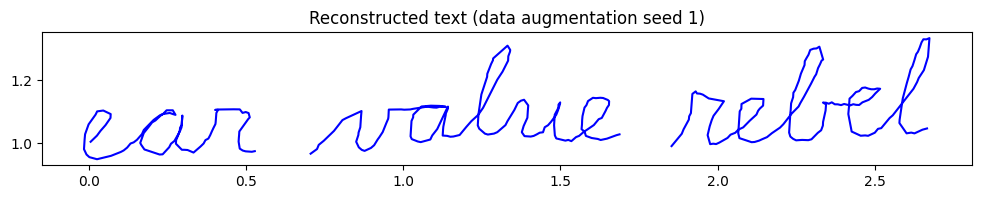

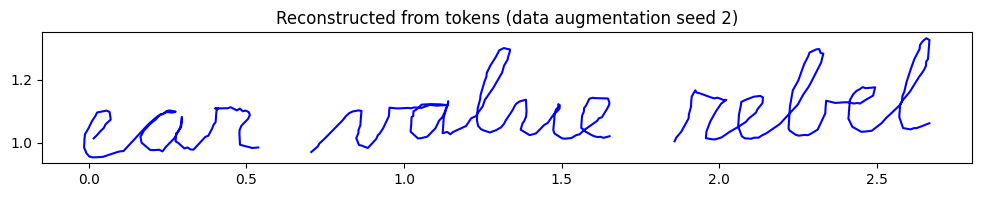

In [10]:
np.random.seed(0)
example_ix = 10
x1, c1, y1 = dataset[example_ix]  # Get tokenized version of the second example
x2, c2, y2 = dataset[example_ix]

o1 = dataset.decode_stroke(x1)
r1 = offsets_to_strokes(o1)
fig, ax = plot_strokes(r1, title='Reconstructed text (data augmentation seed 1)')

o2 = dataset.decode_stroke(x2)
print(o2.shape[0]*2)
r2 = offsets_to_strokes(o2)
fig, ax = plot_strokes(r2, title='Reconstructed from tokens (data augmentation seed 2)')

In [11]:
decoded_stroke = o2#dataset.decode_stroke(x)
decoded_text = c1 #dataset.decode_text(c)

print("Original stroke shape:", (1082,3))
print("Encoded stroke shape:", x1.shape)
print("Encoded text shape:", c1.shape)
print("Decoded stroke shape:", decoded_stroke.shape)

print("\nEncoded strokes (first 10 tokens, aka 5 pen strokes):")
print([v.item() for v in x1[:10]])
print("\n\nEncoded text (first 10 tokens, aka ascii chars):")
print(c1[:10])
print("\nDecoded stroke (first 5 rows, aka 5 pen steps):")
print(decoded_stroke[:5])
print("\nInferred number of tokens required to represent:")
print(decoded_stroke.shape[0]*2)
print("\nDecoded text:")
print(dataset.decode_text(c1))

Original stroke shape: (1082, 3)
Encoded stroke shape: torch.Size([1100])
Encoded text shape: torch.Size([50])
Decoded stroke shape: (423, 3)

Encoded strokes (first 10 tokens, aka 5 pen strokes):
[89, 229, 85, 252, 79, 242, 82, 248, 78, 252]


Encoded text (first 10 tokens, aka ascii chars):
tensor([ 5,  1, 18, 27, 22,  1, 12, 21,  5, 27])

Decoded stroke (first 5 rows, aka 5 pen steps):
[[-0.7400196   0.02153061  1.        ]
 [-0.76794487  0.01418367  1.        ]
 [-0.85172067  0.01693878  1.        ]
 [-0.76794487  0.01510204  1.        ]
 [-1.13097336  0.01234694  1.        ]]

Inferred number of tokens required to represent:
846

Decoded text:
ear value rebel


## Model

In [12]:
class CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_ctx_head == 0
        # query projections for all heads
        self.c_attn_q = nn.Linear(config.n_embd, config.n_embd)
        # key, value projections for all heads
        self.c_attn_kv = nn.Linear(config.n_embd, 2 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.n_ctx_head = config.n_ctx_head
        self.n_embd = config.n_embd

    def forward(self, x, context):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        _, T_ctx, _ = context.size()

        # calculate query for all heads in batch and move head forward to be the batch dim
        q = self.c_attn_q(x).view(B, T, self.n_ctx_head, C // self.n_ctx_head).transpose(1, 2) # (B, nh, T, hs)

        # calculate key, values for all heads in batch and move head forward to be the batch dim
        k, v = self.c_attn_kv(context).split(self.n_embd, dim=2)
        k = k.view(B, T_ctx, self.n_ctx_head, C // self.n_ctx_head).transpose(1, 2) # (B, nh, T_ctx, hs)
        v = v.view(B, T_ctx, self.n_ctx_head, C // self.n_ctx_head).transpose(1, 2) # (B, nh, T_ctx, hs)

        # cross-attention; (B, nh, T, hs) x (B, nh, hs, T_ctx) -> (B, nh, T, T_ctx)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T_ctx) x (B, nh, T_ctx, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

In [13]:
# -----------------------------------------------------------------------------
# Transformer Language Model (*exactly* as used in GPT-2)

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.cross_attn = CrossAttention(config) # NEW
        self.ln_3 = nn.LayerNorm(config.n_embd) # NEW
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x))) # MLP forward

    def forward(self, x, context):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross_attn(self.ln_2(x), context)
        x = x + self.mlpf(self.ln_3(x))
        return x

class Transformer(nn.Module):
    """ Transformer Language Model, exactly as seen in GPT-2 """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            wce = nn.Embedding(config.context_vocab_size, config.n_embd), # NEW
            wcpe = nn.Embedding(config.context_block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("Number of Transformer parameters: {:.0f}".format(n_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, context, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        # forward the GPT model itself
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb

        context_t = context.size(-1)
        context_pos = torch.arange(0, context_t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
        context_emb = self.transformer.wce(context) # context embeddings of shape (b, t_ctx, n_embd)
        context_pos_emb = self.transformer.wcpe(context_pos)
        c = context_emb + context_pos_emb

        if self.config.ablate_cross_attention:
          c = torch.zeros_like(c)

        for block in self.transformer.h:
            x = block(x, c)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

@dataclass
class ModelConfig:
    block_size: int = None # length of the input sequences of integers
    context_block_size: int = None
    vocab_size: int = None # the input integers are in range [0 .. vocab_size -1]
    context_vocab_size: int = None # size of the context vocabulary (ASCII characters)
    context_length: int = None # maximum length of the context sequence
    # parameters below control the sizes of each model slightly differently
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4
    n_ctx_head: int = 4 # number of heads for cross-attention
    ablate_cross_attention: bool = False

## Hyperparameters

In [14]:
def get_time_string(fmt='%m%d_%H%M'):
    return datetime.now().strftime(fmt)

run_tag = "ct_50ksamples_permute"

@dataclass
class AppConfig:
    # system/input/output
    input_file: str = 'names.txt'
    work_dir: str = 'out'
    resume: bool = False
    sample_only: bool = False
    num_workers: int = 1 # 4
    max_steps: int = 30000
    device: str = 'cuda'
    seed: int = 3407

    # sampling
    top_k: int = -1

    # model configuration
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4
    ablate_cross_attention: bool = False  # New flag to ablate cross-attention
    augment: bool = True
    max_seq_length: int = 1100

    # optimization
    batch_size: int = 32
    learning_rate: float = 3e-3
    weight_decay: float = 1e-2

    # wandb parameters
    wandb_project: str = run_tag
    wandb_entity: str = 'sam-greydanus'  # Set this to your wandb username or team name
    wandb_run_name: str = f"{get_time_string()}_{run_tag}"

args = AppConfig()

# system inits
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
os.makedirs(args.work_dir, exist_ok=True)
writer = SummaryWriter(log_dir=args.work_dir)

# init datasets
train_dataset, test_dataset = create_datasets(augment=args.augment, max_seq_length=args.max_seq_length)
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_stroke_seq_length()
context_block_size = train_dataset.get_text_seq_length()
context_vocab_size = train_dataset.get_char_vocab_size()
print(f"Dataset determined that: {vocab_size=}, {block_size=}")

# init model
config = ModelConfig(vocab_size=vocab_size,
                     block_size=block_size,
                     context_block_size=context_block_size,
                     context_vocab_size=context_vocab_size,
                     n_layer=args.n_layer, n_head=args.n_head,
                     n_embd=args.n_embd, n_embd2=args.n_embd2,
                     ablate_cross_attention=args.ablate_cross_attention,
                     n_ctx_head=args.n_head,)
model = Transformer(config)
model.to(args.device)
print(f"Model #params: {sum(p.numel() for p in model.parameters())}")
if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
    print("resuming from existing model in the workdir")
    model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
if args.sample_only:
    # save_samples(num=50)
    print('This functionality is temporarily commented out')
    sys.exit()

# init optimizer and batch loader
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay, betas=(0.9, 0.99), eps=1e-8)
batch_loader = InfiniteDataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, num_workers=args.num_workers)

Saving 0350-bigbank.json to 0350-bigbank (1).json
For a dataset of 316 examples we can generate 5209260 combinations of 3 examples.
Generating 49000 random (and thus possibly overlapping) combos...
For a dataset of 35 examples we can generate 6545 combinations of 3 examples.
Generating 1000 random (and thus possibly overlapping) combos...
Number of examples in the train dataset: 49000
Number of examples in the test dataset: 1000
Max token sequence length: 1100
Number of unique characters in the ascii vocabulary: 27
Ascii vocabulary:
	"abcdefghijklmnopqrstuvwxyz "
Split up the dataset into 49000 training examples and 1000 test examples
Dataset determined that: vocab_size=570, block_size=1100
Number of Transformer parameters: 379008
Model #params: 415488


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [15]:
wandb.init(
    project=args.wandb_project,
    entity=args.wandb_entity,
    name=args.wandb_run_name,
    config=args
)

wandb.config.update({
    "n_layer": config.n_layer,
    "n_head": config.n_head,
    "n_embd": config.n_embd,
    "learning_rate": args.learning_rate,
    "weight_decay": args.weight_decay,
    "batch_size": args.batch_size,
    "ablate_cross_attention": args.ablate_cross_attention,
})

wandb: Currently logged in as: sam-greydanus. Use `wandb login --relogin` to force relogin


## Sample from the untrained model

In [16]:
@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        batch = [t.to(args.device) for t in batch]
        X, C, Y = batch
        logits, loss = model(X, C, Y)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

@torch.no_grad()
def generate(model, idx, context, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    block_size = model.get_block_size()
    steps = max(0, max_new_tokens-idx.size(1))
    for i in range(steps):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond, context)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # either sample from the distribution or take the most likely element
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def save_samples(model, dataset, num=2, model_device='cpu', warmup_steps=100, do_sample=False):
    """ samples from the model and plots the decoded strokes """
    model_device = list(model.parameters())[0].device # hacky

    stroke_seq, context = [], []
    for i in range(num):
      x, c, y = dataset[i]
      stroke_seq.append(x) ; context.append(c)

    X_init = torch.stack(stroke_seq).to(model_device)[:,:warmup_steps]
    context = torch.stack(context).long().to(model_device)
    top_k = None
    steps = dataset.get_stroke_seq_length() - 1  # -1 because we already start with the first token

    X_samp = generate(model, X_init, context, steps, top_k=top_k, do_sample=do_sample).to('cpu')

    for i in range(X_samp.size(0)):
        # get the i'th row of sampled integers, as python list
        row = X_samp[i].detach().cpu().numpy()
        offset_samp = dataset.decode_stroke(row)
        point_samp = offsets_to_strokes(offset_samp)
        decoded_ascii = dataset.decode_text(context[i])

        # Plot the stroke
        fig, ax = plot_strokes(point_samp, f'Sample {i+1}: "{decoded_ascii}"') #plt.axis('off')
        tag = 'sample' if do_sample else 'topk'
        fig.savefig(f"{dataset.name}_{tag}_{i+1}.png")
        wandb.log({f"{dataset.name}_{tag}_{i+1}": wandb.Image(f"{dataset.name}_{tag}_{i+1}.png")})
        plt.close(fig)
        print(f"Saved {dataset.name}_{tag}_{i+1}.png")

    print('-'*80)

## Train the model

In [ ]:
# training loop
best_loss = None
step = 0
while True:

    t0 = time.time()

    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to(args.device) for t in batch]
    X, C, Y = batch

    # feed into the model
    logits, loss = model(X, C, Y)

    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True) ; loss.backward()
    optimizer.step()
    wandb.log({"train_loss_step": loss.item(), "step": step})

    # wait for all CUDA work on the GPU to finish then calculate iteration time taken
    if args.device.startswith('cuda'):
        torch.cuda.synchronize()
    t1 = time.time()

    # logging
    if step % 100 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

    # evaluate the model
    if step > 0 and step % 2000 == 0:
        train_loss = evaluate(model, train_dataset, batch_size=100, max_batches=10)
        test_loss  = evaluate(model, test_dataset,  batch_size=100, max_batches=10)
        wandb.log({"train_loss": train_loss, "test_loss": test_loss, "step": step })
        print(f"step {step} train loss: {train_loss:.4f} test loss: {test_loss:.4f}")
        # save the model to disk if it has improved
        if best_loss is None or test_loss < best_loss:
            out_path = os.path.join(args.work_dir, "model.pt")
            print(f"Test loss {test_loss:.4f} is the best so far, saving model to {out_path}")
            torch.save(model.state_dict(), out_path)
            #wandb.save(out_path)
            best_loss = test_loss

    # sample from the model
    if step > 0 and step % 2000 == 0:
        save_samples(model, test_dataset, num=3, do_sample=True)
        save_samples(model, test_dataset, num=3, do_sample=False)
        save_samples(model, train_dataset, num=3, do_sample=True)
        save_samples(model, train_dataset, num=3, do_sample=False)
    step += 1
    # termination conditions
    if args.max_steps >= 0 and step >= args.max_steps:
        break

step 0 | loss 6.5110 | step time 2199.81ms
step 100 | loss 4.2726 | step time 403.35ms
step 200 | loss 4.2106 | step time 407.50ms
step 300 | loss 4.1617 | step time 415.39ms
step 400 | loss 4.0678 | step time 410.78ms
step 500 | loss 4.0360 | step time 415.68ms
step 600 | loss 3.8927 | step time 412.07ms
step 700 | loss 3.8855 | step time 413.94ms
step 800 | loss 3.7436 | step time 413.58ms
step 900 | loss 3.7842 | step time 410.89ms
step 1000 | loss 3.7245 | step time 410.49ms
step 1100 | loss 3.5199 | step time 413.75ms
step 1200 | loss 3.4348 | step time 412.58ms
step 1300 | loss 3.3108 | step time 409.47ms
step 1400 | loss 3.2571 | step time 410.56ms
step 1500 | loss 3.3434 | step time 410.29ms
step 1600 | loss 3.3268 | step time 410.01ms
step 1700 | loss 3.3023 | step time 410.46ms
step 1800 | loss 3.2610 | step time 410.11ms
step 1900 | loss 3.2260 | step time 411.57ms
step 2000 | loss 3.2699 | step time 410.51ms
step 2000 train loss: 3.2546 test loss: 3.2856
Test loss 3.2856 is

In [ ]:
wandb.finish()

In [ ]:
plt.figure(dpi=200)
img = mpimg.imread('test_sample_1.png')
plt.imshow(img) ; plt.axis('off') ; plt.show()